#**Quick Panel**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
random_seed = 37

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Set-up

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'widsdatathon2024-challenge1:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F65862%2F7469115%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240202%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240202T123452Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5ea2a6dc6b6083c95b5192151c80938ecf30286709850fe096a811a0269d49e1b0f7bf31747c4d315e4cbc6fb1006d04306c862d5c54a8a0848b554296ea3c63c75d85874fba9a9cab9606adee922685d06ffe592eb4ce09848c2f0c7845d819a933fed4b30ecb63cc60573f2e3c5a500a9393c64907daaaa295ddb48c6698398de536a402b0a7378d4f194b88a41179d3f706b25fe420c4a47fdb4bb7413a6a6be90da1912bf37902cb02368bc8f0fb87cb249fbccdde689afe8024b55838b881dff4e97141ac607021ed210a03d6c39644198805c402bffadfba05f22280562ee0bd63465ee6ab43605d90efbb707f298ffd7b0031d95a78b71dc68300d2a9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5281541 bytes downloaded
Downloaded and uncompressed: widsdatathon2024-challenge1
Data source import complete.


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.7 MB/s eta 0:00:00


# WIDS 2024 TUTORIAL DAY-1

The data challenge involves predicting whether patients diagnosed with breast cancer received a metastatic cancer diagnosis within 90 days of screening, using a rich dataset enriched with demographic, treatment, insurance, socio-economic, and toxicology data. This tutorial is aimed at beginners, focusing on helping them understand the dataset and providing basic techniques for machine learning. It will guide newcomers through the process of working with the data and implementing fundamental machine learning approaches to tackle the challenge effectively.


# Import Needed Packages


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import math
import matplotlib.pyplot as plt
import seaborn as sns
import shap as shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import torch
warnings.filterwarnings("ignore")

In [ ]:
# Use Jupyter Widges Package - https://ipywidgets.readthedocs.io/en/stable/index.html
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
style = {'description_width': 'initial'}

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 300)

# Load Train and Test Data Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Not using
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_train = pd.read_csv(path + "train_AC.csv", sep=',')
df_test = pd.read_csv(path + "test_AC.csv", sep=',')

/kaggle/input/widsdatathon2024-challenge1/test.csv
/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv
/kaggle/input/widsdatathon2024-challenge1/training.csv


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
## Load the data
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_train = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/training.csv", sep=',')
df_test = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/test.csv", sep=',')

/kaggle/input/widsdatathon2024-challenge1/test.csv
/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv
/kaggle/input/widsdatathon2024-challenge1/training.csv


In [ ]:
# Check the number of rows and columns
print("Number of train samples are",df_train.shape)
print("Number of test samples are",df_test.shape)

Number of train samples are (12906, 83)
Number of test samples are (5792, 82)


# Text replacement

In [ ]:
import pandas as pd

df_train_stemmed = df_train.copy()
df_test_stemmed = df_test.copy()

# Assuming df_train_data_imputed contains your DataFrame with the column 'A' containing sentence strings
# Create a list of words to detect, including "unspecified" and "unsp"
words_to_detect = ["unsp", "right", "left", "upper", "outer", "overlap", "central", "axillary", "inner", "secondary", "nipple"]
# words_to_detect2 = ["unspecified", "unsp"]

# Create a new column to represent the presence of any of the specified words
for word in words_to_detect:
        df_train_stemmed[word] = df_train_stemmed['breast_cancer_diagnosis_desc'].apply(lambda x: int(any(word in x.lower() for word in words_to_detect)))
        df_test_stemmed[word] = df_test_stemmed['breast_cancer_diagnosis_desc'].apply(lambda x: int(any(word in x.lower() for word in words_to_detect)))

# Now, df_train_data_imputed contains an additional column 'presence_of_any_word'
df_train_stemmed = df_train_stemmed.drop(columns="breast_cancer_diagnosis_desc")
df_test_stemmed = df_test_stemmed.drop(columns="breast_cancer_diagnosis_desc")

df_train = df_train_stemmed
df_test = df_test_stemmed


# Check for Duplicate Records

Duplicate records in a dataset can lead to inaccurate analysis by skewing results, causing data redundancy, and reducing the quality of insights. Identifying and removing these duplicates helps to ensure data integrity and reliability for accurate analysis.

The duplicated() method returns a Boolean Series where each True represents a duplicate row, and the sum() method counts how many True values are there, effectively counting the duplicates.

In [ ]:
num_duplicates = df_train.duplicated().sum()

print("Number of duplicate rows: ", num_duplicates)

Number of duplicate rows:  0


**Dropping Duplicate Records**

Duplicates can be removed using pandas with the DataFrame.drop_duplicates() method. This method identifies and eliminates duplicate rows, keeping only the first occurrence of each unique record. Since for this dataset we found no duplicate records, the we don't use the drop_duplicates() method.

In [ ]:
#df_train.drop_duplicates(inplace=True)

# Check for Missing Values

Checking for missing values is important because most machine learning algorithms assume data to be complete, and gaps can lead to incorrect analysis.


Here we have a method check_missing_values() to analyze missing values in a pandas DataFrame.

- Identify Missing Columns: It identifies which columns in the DataFrame contain any missing (NaN) values.

- Count Missing Values: The function then calculates the total count of missing values for each column.

- Summarize Missing Data: A new DataFrame is created, summarizing the count and percentage of missing values for each column.


In [ ]:
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df

This summarized data is then sorted in descending order to get a clear overview of which columns have the most significant number of missing entries.

In [ ]:
df = check_missing_values(df_train)
print(df.sort_values(by='Missing Values', ascending=False))

                                       Missing Values  Percentage
metastatic_first_novel_treatment                12882   99.814040
metastatic_first_novel_treatment_type           12882   99.814040
bmi                                              8965   69.463815
patient_race                                     6385   49.473113
payer_type                                       1803   13.970246
Region                                             52    0.402913
Division                                           52    0.402913
patient_state                                      51    0.395165
PM25                                               29    0.224702
Ozone                                              29    0.224702
N02                                                29    0.224702
income_household_75_to_100                          4    0.030993
income_household_150_over                           4    0.030993
income_household_15_to_20                           4    0.030993
income_hou

# Handling Missing Data

In [ ]:
df_train_dropped_columns = df_train.drop(columns=df_train.columns[df_train.isnull().mean() > 0.3])

print("No. of columns before dropping: ", df_train.shape[1] )
print("No. of columns after dropping: ", df_train_dropped_columns.shape[1] )
print(df_train.shape[1]- df_train_dropped_columns.shape[1]," columns dropped")

# Identify which columns were dropped
dropped_columns = df_train.columns.difference(df_train_dropped_columns.columns)

print(dropped_columns)

df_test_dropped_columns = df_test.drop(columns=dropped_columns)

No. of columns before dropping:  93
No. of columns after dropping:  89
4  columns dropped
Index(['bmi', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'patient_race'],
      dtype='object')


Now we again check for missing values in the modified train set.



In [ ]:
print("Train set shape: ",df_train_dropped_columns.shape)
print("Test set shape: ",df_test_dropped_columns.shape)

Train set shape:  (12906, 89)
Test set shape:  (5792, 88)


# Imputation

In [ ]:
df_train_data = df_train_dropped_columns.drop('DiagPeriodL90D', axis=1)
df_train_labels = df_train_dropped_columns['DiagPeriodL90D']

df_test_data = df_test_dropped_columns.copy()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

# Combine df_train_data and df_test
combined_data = pd.concat([df_train_data, df_test_data], axis=0)

# Separate numerical and categorical columns
numerical_cols = combined_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = combined_data.select_dtypes(include=['object']).columns

# Initialize KNN imputer for numerical features
numerical_imputer = KNNImputer(n_neighbors=3)  # You can adjust the number of neighbors

# Impute numerical features
combined_data[numerical_cols] = numerical_imputer.fit_transform(combined_data[numerical_cols])

# Fill "Missing" for categorical features
combined_data[categorical_cols] = combined_data[categorical_cols].fillna("Missing")

# Split the combined data back into df_train_data and df_test
df_train_data_imputed = combined_data.iloc[:len(df_train_data)]
df_test_data_imputed = combined_data.iloc[len(df_train_data):]

# Now, df_train_data_imputed and df_test_imputed contain imputed values for both numerical and categorical features



In [ ]:
#Check the shapes of train and test set
print("Train set shape: ",df_train_data_imputed.shape)
print("Test set shape: ",df_test_data_imputed.shape)

Train set shape:  (12906, 88)
Test set shape:  (5792, 88)


# Isolating Outliers

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Concatenate df_train_data_scaled with df_train_labels_balanced
combined_data = pd.concat([df_train_data_imputed, df_train_labels], axis=1)

# Select only the numeric features
num_train = combined_data.select_dtypes('number')

# Initialize Isolation Forest
iso = IsolationForest(contamination=0.01)

# Apply Isolation Forest to identify outliers
outliers = iso.fit_predict(num_train)

# Identify the indices of outliers in the original dataset
outlier_indices = num_train.index[outliers == -1]

# Display the rows that were removed (outliers)
removed_rows = combined_data.loc[outlier_indices]
print("Removed Rows (Outliers):")
print(removed_rows)

# Create a new DataFrame df_train_data_isolated without outliers
df_train_isolated = combined_data[outliers != -1]

# Separate the feature data and labels
df_train_labels_isolated = df_train_isolated['DiagPeriodL90D']  # Extract the labels
df_train_data_isolated = df_train_isolated.drop(columns=['DiagPeriodL90D'])  # Remove the label column

# Now df_train_data_isolated contains the feature data without outliers, and df_train_labels_isolated contains the corresponding labels.


Removed Rows (Outliers):
       patient_id          payer_type patient_state  patient_zip3  \
59       908063.0          COMMERCIAL            NY         117.0   
94       797586.0          COMMERCIAL            NY         113.0   
105      933068.0            MEDICAID            NY         112.0   
161      680056.0          COMMERCIAL            CA         946.0   
176      662300.0          COMMERCIAL            TX         758.0   
259      433286.0          COMMERCIAL            CA         959.0   
424      683174.0             Missing            CA         907.0   
457      547229.0          COMMERCIAL            MN         554.0   
576      909977.0          COMMERCIAL            CA         950.0   
606      357948.0          COMMERCIAL            AR         721.0   
616      717368.0  MEDICARE ADVANTAGE            PA         183.0   
706      607776.0          COMMERCIAL            CA         940.0   
796      822497.0          COMMERCIAL            IL         606.0   
880      

# Check for Imbalanced Classes

Class imbalance can significantly impact the performance of machine learning models, leading to biased predictions favoring the majority class. Hence, it is important to identify and address this to ensure accurate and fair model outcomes.

A common guideline is to consider a dataset imbalanced if the minority class constitutes less than 20% of the total data. However, this threshold can vary based on specific domain requirements and the nature of the dataset.

No. of instances per class
1    8060
0    4846
Name: DiagPeriodL90D, dtype: int64


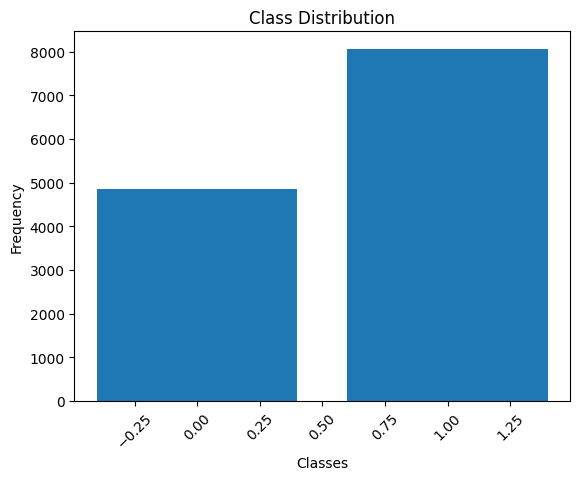

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def check_class_distribution(df):

    # Count the number of classes
    class_counts = df.value_counts()

    # Display the number of instances per class
    print("No. of instances per class")
    print(class_counts)

    # Plotting the bar graph for class distribution
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()


check_class_distribution(df_train_labels)

# Handling Class Imbalance
Here class 1 is the majority class and class 0 is the minority class. Whether the data is imbalanced depends on your specific dataset. One naive approach to balance a dataset is by randomly undersampling the majority class. This involves randomly removing some instances from the majority class to match the number of instances in the minority class.  

In [ ]:
import pandas as pd

# Assuming df_train_data_imputed contains your feature data and df_train_labels contains your labels
# Combine the feature data and labels into one DataFrame
balanced_df = pd.concat([df_train_data_isolated, df_train_labels_isolated], axis=1)

# Separate the data into two DataFrames based on the class labels
class_0 = balanced_df[balanced_df['DiagPeriodL90D'] == 0]
class_1 = balanced_df[balanced_df['DiagPeriodL90D'] == 1]

# Calculate the ratio of samples in class 0 to class 1
class_0_count = len(class_0)
class_1_count = len(class_1)
ratio = class_0_count / class_1_count

# Duplicate rows from class 1 to balance the dataset
if ratio < 1:
    duplicates_needed = int(class_1_count - class_0_count)
    duplicates = class_0.sample(n=duplicates_needed, replace=True, random_state=42)
    class_0_balanced = pd.concat([class_0, duplicates])
    balanced_df = pd.concat([class_1, class_0_balanced])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate the balanced dataset back into feature data and labels
df_train_data_balanced = balanced_df.drop(columns=['DiagPeriodL90D'])
df_train_labels_balanced = balanced_df['DiagPeriodL90D']

# Now df_train_data_balanced and df_train_labels_balanced contain the balanced dataset


# Encoding Categorical Vaiables

In [ ]:
import pandas as pd

# Assuming df_train_data_imputed and df_test_data_imputed contain your data
# Concatenate the train and test datasets to ensure consistent one-hot encoding
combined_imputed_data = pd.concat([df_train_data_balanced, df_test_data_imputed], axis=0)

# Separate numerical and categorical columns
numerical_cols = combined_imputed_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = combined_imputed_data.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical columns
combined_data_encoded = pd.get_dummies(combined_imputed_data, columns=categorical_cols, drop_first=True)

# Split the combined data back into train and test datasets
df_train_data_encoded = combined_data_encoded.iloc[:len(df_train_data_balanced)]
df_test_data_encoded = combined_data_encoded.iloc[len(df_train_data_balanced):]

# Now, train_data_encoded and test_data_encoded contain one-hot encoded features


In [ ]:
df_train_data_encoded.to_csv(path + 'df_train_data_encoded.csv', index = False)

# Preprocessing

In [ ]:
### MinMax Scaling

from sklearn.preprocessing import MinMaxScaler

mnscaler = MinMaxScaler()
df_train_data_scaled = mnscaler.fit_transform(df_train_data_encoded)

df_test_data_scaled = mnscaler.transform(df_test_data_encoded)


**balancing(not using)**

In [ ]:
import pandas as pd
import numpy as np

# Assuming df_train_data_scaled and df_train_labels are your data and labels dataframes
# Combine the data and labels into a single dataframe
balanced_df = pd.concat([pd.DataFrame(df_train_data_scaled), pd.Series(df_train_labels)], axis=1)

# Separate the data into two dataframes based on the label
df_label_0 = balanced_df[balanced_df['DiagPeriodL90D'] == 0]
df_label_1 = balanced_df[balanced_df['DiagPeriodL90D'] == 1]

# Calculate the difference in counts between the two classes
count_label_0 = len(df_label_0)
count_label_1 = len(df_label_1)
count_difference = count_label_1 - count_label_0

# Duplicate rows from the dataframe with label 1 to balance the classes
if count_difference > 0:
    # Randomly sample rows from df_label_1 with replacement to match the count
    duplicated_rows = df_label_0.sample(n=count_difference, replace=True, random_state=42)
    # Concatenate the duplicated rows with the original data
    balanced_df = pd.concat([df_label_0, df_label_1, duplicated_rows], axis=0)

# Separate the balanced dataframe back into data and labels
df_train_data_balanced = balanced_df.drop(columns=['DiagPeriodL90D'])
df_train_labels_balanced = balanced_df['DiagPeriodL90D']

# Now, df_train_data_balanced and df_train_labels_balanced contain balanced data


**train test split(not using)**

In [ ]:
### Train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_data_scaled, df_train_labels_balanced, test_size=0.1, random_state = random_seed)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train.to_numpy())

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test.to_numpy())

# Model Building

## MLP + MSELoss

In [ ]:
from torch.nn import Module, MSELoss, Linear, Dropout
from torch.optim import SGD
import math

dtype = torch.float
device = torch.device("cpu")

def threshold_tensor(tensor, threshold=0.5):
    return (tensor > threshold).float()

class Basic_MLP_Model(torch.nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
            """ input_layer: 1 number,
                hidden_layer: a list of numbers nominating the hidden_layer size.
                              for example, [2,3,4,5]
                output_layer: size of output neurals

            """
            super().__init__()

            if len(hidden_size) <= 0:
                raise ValueError("too few hidden layers ")


            self.num_layers = len(hidden_size) + 2
            self.input_layer = Linear(input_size, hidden_size[0])

            self.hidden_layers = [Linear(hidden_size[i-1], hidden_size[i]) for i in range(1,len(hidden_size),1)]
            self.output_layer = Linear(hidden_size[-1], output_size)

            self.dropout = Dropout(p=0.1)
            self.relu = torch.nn.functional.relu
            self.sigmoid = torch.nn.functional.sigmoid

      def forward(self, X):

            ### input layer
            X = self.dropout(self.relu(self.input_layer(X)))

            ### hidden layer
            for layer in self.hidden_layers:
                  X = self.dropout(self.relu(layer(X)))

            ### output layer
            X = self.output_layer(X)
            X = self.sigmoid(X)
            return X


## MLP feedforward

In [ ]:
from torch.nn import Module, MSELoss, Linear, Dropout
from torch.optim import SGD
import math

dtype = torch.float
device = torch.device("cpu")

class FeedforwardMLP_Model(torch.nn.Module):
      def __init__(self, input_size, hidden_size, feedforward_size, output_size = [128, 64, 1]):
            """ input_size: 1 number,
                hidden_size: a list of numbers nominating the hidden_layer size.
                              for example, [2,3,4,5]
                feedforward_size: a list of numbers nominating the feedforward_layer size, but has to be the same.
                              for example, [5,5,5,5]
                output_size: 3 numbers nominating the output_layer size.
                              for example, [2,3,4,5]

            """
            super().__init__()

            if len(hidden_size) <= 0:
                raise ValueError("too few hidden layers ")


            self.num_layers = len(hidden_size) + 2
            self.input_layer = Linear(input_size, hidden_size[0])

            self.hidden_layers = [Linear(hidden_size[i-1], hidden_size[i]) for i in range(1,len(hidden_size),1)]

            self.transit_layer = Linear(hidden_size[-1], feedforward_size[0])

            self.feedforward_layers = [Linear(feedforward_size[i-1], feedforward_size[i]) for i in range(1,len(feedforward_size),1)]

            self.output_layer1 = Linear(feedforward_size[-1], output_size[0])
            self.output_layer2 = Linear(output_size[0], output_size[1])
            self.output_layer3 = Linear(output_size[1], output_size[2])

            self.dropout = Dropout(p=0.1)
            self.relu = torch.nn.functional.relu
            self.sigmoid = torch.nn.functional.sigmoid

      def forward(self, X):

            ### input layer
            X = self.dropout(self.relu(self.input_layer(X)))

            ### hidden layer
            for layer in self.hidden_layers:
                  X = self.dropout(self.relu(layer(X)))

            X = self.relu(self.transit_layer(X))

            ### feedforward layer
            for layer in self.feedforward_layers:
                  X = self.dropout(self.relu(layer(X))) + X

            ### output layer
            X = self.relu(self.output_layer1(X))
            X = self.relu(self.output_layer2(X))
            X = self.output_layer3(X)
            X = self.sigmoid(X)
            return X


# Model Training

In [ ]:
features = torch.Tensor(torch.Tensor(df_train_data_scaled))
labels = torch.Tensor(torch.Tensor(df_train_labels_balanced))

input_size = features.shape[1]
hidden_size = [512, 1024, 256]
feedforward_size = [512, 512, 512]
output_size = 1

model = Basic_MLP_Model(input_size, hidden_size, output_size)

###################333

from torch.utils.data.dataset import random_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


num_epochs = 20

num_samples = features.shape[0]
num_train_samples = int(num_samples * 0.9)
num_val_samples = num_samples - num_train_samples

train_dataset, val_dataset = random_split(TensorDataset(features, labels), [num_train_samples, num_val_samples],\
                                          generator = torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, generator = torch.Generator().manual_seed(random_seed))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)  # No need to shuffle validation data

In [ ]:
from sklearn.metrics import roc_auc_score

num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_predictions = []  # Store predicted probabilities
    val_targets = []  # Store true labels
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            # Store predicted probabilities and true labels
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    # Calculate AUC for validation
    val_auc = roc_auc_score(val_targets, val_predictions)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}, Validation AUC: {val_auc:.4f}")


Epoch 1/10, Training Loss: 0.1662865872156015
Epoch 1/10, Validation Loss: 0.16779877168066318, Validation AUC: 0.7962
Epoch 2/10, Training Loss: 0.1660922453732319
Epoch 2/10, Validation Loss: 0.16796323961968865, Validation AUC: 0.7959
Epoch 3/10, Training Loss: 0.16584878675210749
Epoch 3/10, Validation Loss: 0.167866109778513, Validation AUC: 0.7970
Epoch 4/10, Training Loss: 0.16556861105705364
Epoch 4/10, Validation Loss: 0.16774699582704447, Validation AUC: 0.7969
Epoch 5/10, Training Loss: 0.16471341074251067
Epoch 5/10, Validation Loss: 0.1704364794505201, Validation AUC: 0.7942
Epoch 6/10, Training Loss: 0.1645966405107158
Epoch 6/10, Validation Loss: 0.16833407687665733, Validation AUC: 0.7974
Epoch 7/10, Training Loss: 0.16403065973735145
Epoch 7/10, Validation Loss: 0.16986876397992187, Validation AUC: 0.7959
Epoch 8/10, Training Loss: 0.1640161457191844
Epoch 8/10, Validation Loss: 0.1684969402809232, Validation AUC: 0.7995
Epoch 9/10, Training Loss: 0.16348649199292767
E

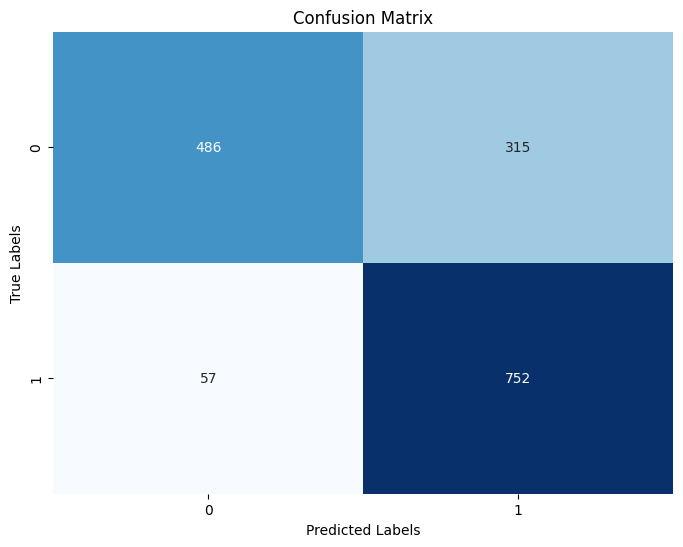

Test Loss: 0.1598, Test Accuracy: 76.89%


In [ ]:




from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# No gradient calculations needed
with torch.no_grad():
    outputs = model(X_test)  # Get model predictions for the test set
    outputs = outputs.squeeze()  # Remove extra dimensions if any
    loss = criterion(outputs, y_test.float())  # Calculate loss
    test_loss = loss.item()

    # Calculate accuracy
    predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()

test_accuracy = correct / total

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test.cpu().numpy(), predicted.cpu().numpy())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
import pandas as pd

# Combine predictions and true labels into a DataFrame
result_df = pd.DataFrame({'True_Labels': y_test, 'Predicted_Labels': predicted})

# Identify mispredictions by comparing true labels with predicted labels
misclassified_rows = result_df[result_df['True_Labels'] != result_df['Predicted_Labels']]

# Print the misclassified rows
print("Misclassified Rows:")
print(misclassified_rows)

# If you want to see the corresponding data for the misclassified rows, you can merge with your original data
# Assuming df_train_data_imputed contains your feature data
misclassified_data = df_train_data_imputed.loc[misclassified_rows.index]

# Print the misclassified data
print("Misclassified Data:")
print(misclassified_data)


In [ ]:
misclassified_data.to_csv(path + 'misclassified.csv')

# Validation

![cross_validation.png](attachment:db6a3093-d295-49aa-864c-92f206f72f1e.png)

Check for details on cross-validation [here](https://scikit-learn.org/stable/modules/cross_validation.html)

In [ ]:
from sklearn.model_selection import cross_val_score
#Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.51857247 0.52367079 0.50764749 0.53095412 0.49125364]
Mean cross-validation score: 0.5144197019146854


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set
y_pred = log_reg.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
confusion = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", confusion)


Accuracy: 0.5081585081585082
Precision: 0.5052770448548812
Recall: 0.4495305164319249
F1 Score: 0.4757763975155279
Confusion Matrix:
 [[489 375]
 [469 383]]


# Train for full data

In [ ]:
input_size = X_train.shape[1]
hidden_size = [128,256,64]
output_size = 1

final_model = Basic_MLP_Model(input_size, hidden_size, output_size)


tensor([[0.5230],
        [0.5239],
        [0.5223],
        ...,
        [0.5216],
        [0.5204],
        [0.5213]], grad_fn=<SigmoidBackward0>)

In [ ]:
from torch.utils.data.dataset import random_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

num_epochs = 20

num_samples = X_train.shape[0]
num_train_samples = int(num_samples * 0.8)
num_val_samples = num_samples - num_train_samples

train_dataset, val_dataset = random_split(TensorDataset(X_train, y_train), [num_train_samples, num_val_samples],\
                                          generator = torch.Generator().manual_seed(random_seed))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, generator = torch.Generator().manual_seed(random_seed))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)  # No need to shuffle validation data

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

input_size = X_train.shape[1]
hidden_size = [128,256,64]
output_size = 1

final_model = Basic_MLP_Model(input_size, hidden_size, output_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay = 0.0001)

num_epochs = 20

# Assuming X_train and y_train are PyTorch tensors

train_loader = DataLoader(TensorDataset(torch.Tensor(df_train_data_scaled), torch.Tensor(df_train_labels.values)), batch_size=8, shuffle=True)

for epoch in range(num_epochs):
    final_model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}")


Epoch 1/20, Training Loss: 0.19884292028447362
Epoch 2/20, Training Loss: 0.17376234148348574
Epoch 3/20, Training Loss: 0.16000412965408045
Epoch 4/20, Training Loss: 0.15476621874484617
Epoch 5/20, Training Loss: 0.15258866579351482
Epoch 6/20, Training Loss: 0.15144395472567246
Epoch 7/20, Training Loss: 0.150705081242214
Epoch 8/20, Training Loss: 0.15008421433117827
Epoch 9/20, Training Loss: 0.14997922711575212
Epoch 10/20, Training Loss: 0.14951808050694926
Epoch 11/20, Training Loss: 0.14950109080929663
Epoch 12/20, Training Loss: 0.1490955742426872
Epoch 13/20, Training Loss: 0.1487330167243878
Epoch 14/20, Training Loss: 0.14825424606666024
Epoch 15/20, Training Loss: 0.14828296410453032
Epoch 16/20, Training Loss: 0.14819497527506162
Epoch 17/20, Training Loss: 0.14839431949426066
Epoch 18/20, Training Loss: 0.14825063532096008
Epoch 19/20, Training Loss: 0.14807807553393357
Epoch 20/20, Training Loss: 0.14794045076111176


# Submission Guide

Once we have the final model, we will use it to predict on our test set *df_test*



In [ ]:
model.eval()

# No gradient calculations needed
with torch.no_grad():
    outputs = model(torch.Tensor(df_test_data_scaled))  # Get model predictions for the test set
    outputs = outputs.squeeze()  # Remove extra dimensions if any

### no need for this
#predictions = (outputs > 0.5).float()
predictions = outputs

submission_df = pd.DataFrame({
    'patient_id': df_test['patient_id'],
    'DiagPeriodL90D': predictions
})
submission_df.head()


# Save the DataFrame as a CSV file
csv_file_path = path + 'submission.csv'
submission_df.to_csv(csv_file_path, index=False)

Submissions are made on Kaggle in the form of CSV files where there will be two columns, the ID of the instance (Here patient_id) and predicted value.

Note: Check the sample_submission.csv